# Sweeps - Impedance, scattering and admittance (Z S Y) matrices

### Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim

## Create the design in Metal
 Set up a design of a given dimension.  Create a design by specifying the chip size and open Metal GUI.  Dimensions will be respected in the design rendering.  Note the chip design is centered at origin (0,0).

In [3]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

# Perform the necessary imports.
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

In [4]:
# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Add 2 transmons to the design.
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width='425 um',
    pocket_height='650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(a=dict(loc_W=+1, loc_H=+1),
                         b=dict(loc_W=-1, loc_H=+1, pad_height='30um'),
                         c=dict(loc_W=+1, loc_H=-1, pad_width='200um'),
                         d=dict(loc_W=-1, loc_H=-1, pad_height='50um')))

## Create 2 transmons
q1 = TransmonPocket(design,
                    'Q1',
                    options=dict(pos_x='+1.4mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))
q2 = TransmonPocket(design,
                    'Q2',
                    options=dict(pos_x='-0.6mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))

gui.rebuild()
gui.autoscale()

In [6]:
# Add 2 hangers consisting of capacitively coupled transmission lines.
TQ1 = CoupledLineTee(design,
                     'TQ1',
                     options=dict(pos_x='1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))
TQ2 = CoupledLineTee(design,
                     'TQ2',
                     options=dict(pos_x='-1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))

gui.rebuild()
gui.autoscale()

In [7]:
# Add 2 meandered CPWs connecting the transmons to the hangers.
ops = dict(fillet='90um')
design.overwrite_enabled = True

options1 = Dict(total_length='8mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                               pin='second_end'),
                                end_pin=Dict(component='Q1', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

options2 = Dict(total_length='9mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                               pin='second_end'),
                                end_pin=Dict(component='Q2', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

meanderQ1 = RouteMeander(design, 'meanderQ1', options=options1)
meanderQ2 = RouteMeander(design, 'meanderQ2', options=options2)

gui.rebuild()
gui.autoscale() 

In [8]:
# Add 2 open to grounds at the ends of the horizontal CPW.
otg1 = OpenToGround(design, 'otg1', options=dict(pos_x='3mm', pos_y='3mm'))
otg2 = OpenToGround(design,
                    'otg2',
                    options=dict(pos_x='-3mm', pos_y='3mm', orientation='180'))

gui.rebuild()
gui.autoscale()

# Add 3 straight CPWs that comprise the long horizontal CPW.

ops_oR = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ1', pin='prime_end'),
                              end_pin=Dict(component='otg1', pin='open')))
ops_mid = Dict(hfss_wire_bonds=True,
               pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                              pin='prime_start'),
                               end_pin=Dict(component='TQ2', pin='prime_end')))
ops_oL = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                             pin='prime_start'),
                              end_pin=Dict(component='otg2', pin='open')))

cpw_openRight = RouteStraight(design, 'cpw_openRight', options=ops_oR)
cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)
cpw_openLeft = RouteStraight(design, 'cpw_openLeft', options=ops_oL)

gui.rebuild()
gui.autoscale()

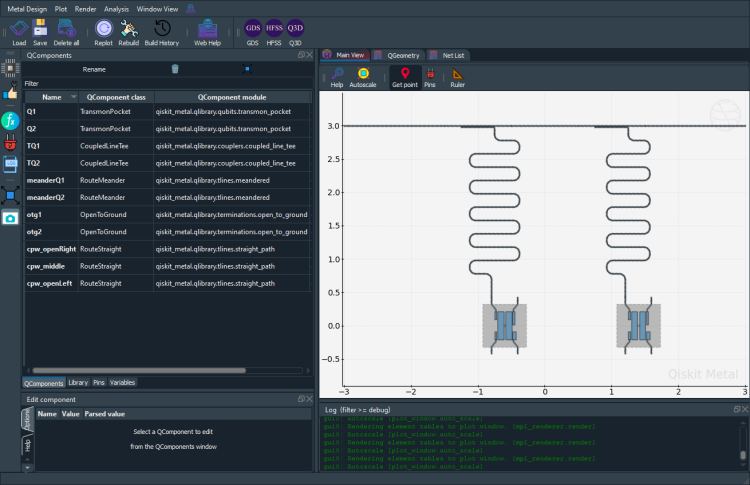

In [9]:
gui.screenshot()

## 2. Render the qubit from Metal into the HangingResonators design in Ansys. <br>ScatteringImpedanceSim will  open the simulation software. Then will connect, activate the design, add a setup.  

Review and update the setup. For driven modal you will need to define not only the simulation convergence parameters, but also the frequency sweep.




In [10]:
em1 = ScatteringImpedanceSim(design, "hfss")

Customizable parameters and default values for HFSS (driven  modal):

    freq_ghz=5 (simulation frequency)
    name="Setup" (setup name)
    max_delta_s=0.1 (absolute value of maximum difference in scattering parameter S)
    max_passes=10 (maximum number of passes)
    min_passes=1 (minimum number of passes)
    min_converged=1 (minimum number of converged passes)
    pct_refinement=30 (percent refinement)
    basis_order=1 (basis order)
    vars (global variables to set in the renderer)
    sweep_setup (all the parameters of the sweep)
    name="Sweep" (name of sweep)
    start_ghz=2.0 (starting frequency)
    stop_ghz=8.0 (stopping frequency)
    count=101 (total number of frequencies)
    step_ghz=None (frequency step size)
    type="Fast" (type of sweep)
    save_fields=False (whether or not to save fields)

In [11]:
# To view the values for defaults. 
em1.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5,
 'max_delta_s': 0.1,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 8.0,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [11]:
em1.setup.name = "Sweep_DrivenModal_setup"
em1.setup.freq_ghz = 6.0
em1.setup.max_delta_s = 0.05
em1.setup.max_passes = 12
em1.setup.min_passes = 2


Add a frequency sweep to a driven modal setup.<br>
From QHFSSRenderer.add_sweep doc_strings.  Please go to doc_strings to get the latest information.  

Args:<br>
    setup_name (str, optional): Name of driven modal simulation Sweep.
                            Defaults to "Setup".<br>
    start_ghz (float, optional): Starting frequency of sweep in GHz.
                            Defaults to 2.0.<br>
    stop_ghz (float, optional): Ending frequency of sweep in GHz.
                            Defaults to 8.0.<br>
    count (int, optional): Total number of frequencies.
                            Defaults to 101.<br>
    step_ghz (float, optional): Difference between adjacent
                            frequencies. Defaults to None.<br>
    name (str, optional): Name of sweep. Defaults to "Sweep".<br>
    type (str, optional): Type of sweep. Defaults to "Fast".<br>
    save_fields (bool, optional): Whether or not to save fields.
                        Defaults to False.<br>
                        
                        
From pyEPR.HfssSetup.insert_sweep(), please go to this method to get the latest documentation.   
You should provide either step_ghz or count when inserting an HFSS driven model freq sweep. Do not provide both or neither!

In [12]:
# To view the values for defaults. 
em1.setup.sweep_setup

{'name': 'Sweep',
 'start_ghz': 2.0,
 'stop_ghz': 8.0,
 'count': 101,
 'step_ghz': None,
 'type': 'Fast',
 'save_fields': False}

In [13]:
em1.setup.sweep_setup.name="Sweep_options__dm_sweep"
em1.setup.sweep_setup.start_ghz=4.0
em1.setup.sweep_setup.stop_ghz=9.0
em1.setup.sweep_setup.count=5001
em1.setup.sweep_setup.type="Interpolating"


em1.setup

{'name': 'Sweep_DrivenModal_setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 6.0,
 'max_delta_s': 0.05,
 'max_passes': 12,
 'min_passes': 2,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep_options__dm_sweep',
  'start_ghz': 4.0,
  'stop_ghz': 9.0,
  'count': 5001,
  'step_ghz': None,
  'type': 'Interpolating',
  'save_fields': False}}

In [14]:
# Set the buffer width at the edge of the design to be 0.5 mm 
# in both directions.
em1.setup.renderer.options['x_buffer_width_mm'] = 0.5
em1.setup.renderer.options['y_buffer_width_mm'] = 0.5

In [16]:
#     qcomp_name (str): A component that contains the option to be swept.
#     option_name (str): The option within qcomp_name to sweep.
#     option_sweep (list): Each entry in the list is a value for
#                 option_name.
#     qcomp_render (list): The component to render to simulation.
#     open_terminations (list): Identify which kind of pins. Follow the
#                 details from renderer QQ3DRenderer.render_design, or
#                 QHFSSRenderer.render_design.
#     port_list (list): List of tuples of jj's that shouldn't
#                     be rendered.  Follow details from
#                     renderer in QHFSSRenderer.render_design.
#     jj_to_port (list): List of junctions (qcomp, qgeometry_name,
#                         impedance, draw_ind) to render as lumped ports
#                         or as lumped port in parallel with a sheet
#                         inductance.    Follow details from renderer
#                         in QHFSSRenderer.render_design.
#     ignored_jjs (Union[list,None]): This is not used by all renderers,
#                  just hfss.
#     design_name(str): Name of design (workspace) to use in project.
#     box_plus_buffer(bool): Render the entire chip or create a
#                 box_plus_buffer around the components which are rendered.


In [15]:

design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin cpw_openRight_end and cpw_openLeft_end are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('cpw_openRight', 'end', 50),
                      ('cpw_openLeft', 'end', 50)]
jj_to_port = [('Q1', 'rect_jj', 50, False)]
# Neither of the junctions in Q1 or Q2 are rendered.
ignored_jjs = [('Q2', 'rect_jj')]
box_plus_buffer = True

In [16]:
#Note: The method will connect to  Ansys simulation, activate_drivenmodal_design(), add_drivenmodal_setup().

all_sweeps, return_code = em1.run_sweep(meanderQ1.name,
                                        'total_length', 
                                        ['9mm', '10mm', '11mm'],
                                        qcomp_render,
                                        open_terminations,
                                        design_name=design_name,
                                        port_list = port_list,
                                        jj_to_port= jj_to_port,
                                        ignored_jjs= ignored_jjs,
                                        box_plus_buffer=box_plus_buffer
                                       )

INFO 03:47PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:47PM [load_ansys_project]: 	Opened Ansys App
INFO 03:47PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 03:47PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project25
INFO 03:47PM [connect_design]: 	Opened active design
	Design:    Q1RO_new2 [Solution type: DrivenModal]
INFO 03:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 03:47PM [connect]: 	Connected to project "Project25" and design "Q1RO_new2" 😀 

INFO 03:47PM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal_hfss [Solution type: DrivenModal]
WARNING 03:47PM [connect_setup]: 	No design setup detected.
WARNING 03:47PM [connect_setup]: 	Creating driven modal default setup.
INFO 03:47PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 03:48PM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.Hf

#Note: Sweep again using the arguments from previous run.  
```
all_sweeps_6_7_8, return_code = em1.run_sweep(meanderQ1.name,
                                        'total_length', 
                                        ['6.5mm', '7.5mm', '8.5mm']
                                       )
```

In [17]:

if return_code == 0:
    # Each key corresponds to list passed to ['9mm', '8mm', '7mm']
    print(all_sweeps.keys())
    
    # Each key corresponds to list passed to ['6mm', '5mm', '4mm']
    # print(all_sweeps_6_7_8.keys())
else:
    print('Check warning messages to see why all_sweeps is non-zero.')


dict_keys(['9mm', '10mm', '11mm'])


In [18]:
all_sweeps['9mm'].keys()

dict_keys(['option_name', 'variables'])

In [19]:
all_sweeps['9mm']['variables']

{'sim_setup_name': 'Sweep_DrivenModal_setup',
 'sweep_name': 'Sweep_options__dm_sweep'}

In [20]:
all_sweeps['9mm']['option_name']


'total_length'

In [21]:
print(f"""
project_name = {em1.renderer.pinfo.project_name}
design_name  = {em1.renderer.pinfo.design_name}
setup_name   = {em1.renderer.pinfo.setup_name}
""")


project_name = Project25
design_name  = Sweep_DrivenModal_hfss
setup_name   = Sweep_DrivenModal_setup



Note: Results storage is currently being updated to be fully functional with the sweep functionality.

In [22]:
em1.get_impedance()                # default: ['Z11', 'Z21']

(                        Z11                   Z21
 4.000   0.000000-12.102079j   0.000000+44.086019j
 4.001  -0.000000-12.087239j   0.000000+44.082102j
 4.002  -0.0000-0012.072400j   0.00000+044.078190j
 4.003  -0.000000-12.057563j   0.000000+44.074282j
 4.004  -0.000000-12.042728j   0.000000+44.070379j
 ...                     ...                   ...
 8.996  0.000003+217.530954j -0.000012+223.195830j
 8.997  0.000002+217.918187j -0.000009+223.575803j
 8.998  0.000001+218.306745j -0.000006+223.957099j
 8.999  0.000001+218.696633j -0.000003+224.339724j
 9.000  0.000000+219.087858j  0.000000+224.723686j
 
 [5001 rows x 2 columns],
 <Figure size 1000x600 with 2 Axes>)

In [23]:
em1.get_admittance()              # default: ['Y11', 'Y21']

(                      Y11                 Y21
 4.000  0.000000-0.006635j -0.000000-0.024504j
 4.001  0.000000-0.006627j  0.000000-0.024502j
 4.002  0.000000-0.006619j  0.000000-0.024500j
 4.003  0.000000-0.006610j  0.000000-0.024497j
 4.004  0.000000-0.006602j  0.000000-0.024495j
 ...                   ...                 ...
 8.996 -0.000000+0.086464j  0.000000-0.088750j
 8.997 -0.000000+0.086571j  0.000000-0.088853j
 8.998 -0.000000+0.086678j  0.000000-0.088956j
 8.999 -0.000000+0.086786j  0.000000-0.089060j
 9.000  0.000000+0.086893j -0.000000-0.089164j
 
 [5001 rows x 2 columns],
 <Figure size 1000x600 with 2 Axes>)

In [24]:
em1.get_scattering(['S11', 'S21', 'S31'])          ## default: ['S11', 'S21', 'S22']

(                      S11                 S21                 S31
 4.000 -0.150716-0.044052j -0.265922+0.951120j -0.000180-0.000108j
 4.001 -0.150740-0.044007j -0.265616+0.951204j -0.000181-0.000109j
 4.002 -0.150765-0.043962j -0.265310+0.951287j -0.000182-0.000109j
 4.003 -0.150790-0.043916j -0.265005+0.951371j -0.000183-0.000110j
 4.004 -0.150815-0.043871j -0.264699+0.951454j -0.000185-0.000111j
 ...                   ...                 ...                 ...
 8.996  0.000333-0.000608j  0.974431+0.224685j -0.000160+0.000129j
 8.997  0.000348-0.000666j  0.974505+0.224364j -0.000159+0.000129j
 8.998  0.000362-0.000723j  0.974579+0.224043j -0.000159+0.000129j
 8.999  0.000377-0.000781j  0.974653+0.223722j -0.000159+0.000129j
 9.000  0.000391-0.000839j  0.974726+0.223400j -0.000159+0.000129j
 
 [5001 rows x 3 columns],
 <Figure size 1000x600 with 2 Axes>)

In [25]:
dataframe_scattering = em1.get_scattering(['S11', 'S21', 'S31'])
df_s = dataframe_scattering[0]

In [66]:
df_s.to_csv("df_s.csv")

In [32]:
dataframe_scattering[1]
plt.show()

In [36]:
s11 = df_s['S11']
s11

s21 = df_s['S21']
s21

s31 = df_s['S31']
s31

4.000   -0.000180-0.000108j
4.001   -0.000181-0.000109j
4.002   -0.000182-0.000109j
4.003   -0.000183-0.000110j
4.004   -0.000185-0.000111j
                ...        
8.996   -0.000160+0.000129j
8.997   -0.000159+0.000129j
8.998   -0.000159+0.000129j
8.999   -0.000159+0.000129j
9.000   -0.000159+0.000129j
Name: S31, Length: 5001, dtype: complex128

In [37]:
dataframe_scattering[0]['20_log_of_mag_S11']= 20 * np.log10(np.absolute(s11))
dataframe_scattering[0]['20_log_of_mag_S21']= 20 * np.log10(np.absolute(s21))
dataframe_scattering[0]['20_log_of_mag_S31']= 20 * np.log10(np.absolute(s31))
dataframe_scattering[0]

,S11,S21,S31,20_log_of_mag_S11,20_log_of_mag_S21,20_log_of_mag_S31
4.000,-0.150716-0.044052j,-0.265922+0.951120j,-0.000180-0.000108j,-16.080811,-0.108421,-73.575420
4.001,-0.150740-0.044007j,-0.265616+0.951204j,-0.000181-0.000109j,-16.080193,-0.108437,-73.517523
4.002,-0.150765-0.043962j,-0.265310+0.951287j,-0.000182-0.000109j,-16.079575,-0.108452,-73.459292
4.003,-0.150790-0.043916j,-0.265005+0.951371j,-0.000183-0.000110j,-16.078958,-0.108468,-73.400723
4.004,-0.150815-0.043871j,-0.264699+0.951454j,-0.000185-0.000111j,-16.078341,-0.108484,-73.341813
...,...,...,...,...,...,...
8.996,0.000333-0.000608j,0.974431+0.224685j,-0.000160+0.000129j,-63.184444,-0.000002,-73.752467
8.997,0.000348-0.000666j,0.974505+0.224364j,-0.000159+0.000129j,-62.487802,-0.000002,-73.756013
8.998,0.000362-0.000723j,0.974579+0.224043j,-0.000159+0.000129j,-61.840272,-0.000003,-73.759547
8.999,0.000377-0.000781j,0.974653+0.223722j,-0.000159+0.000129j,-61.235716,-0.000003,-73.763071


In [38]:
# Reference to current axis. 
magnitude = plt.figure('Magnitude S11, S21, and S31')
plt.clf()
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S11', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S21', color = 'blue', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Magnitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'|S11|,|S21|,|S31| [dB]')
magnitude.show()

In [41]:
# Data is shown as degrees.  
# However, if you want radians, change value of deg to false, deg=False.
dataframe_scattering[0]['degrees_S11'] = np.angle(s11, deg=True)
dataframe_scattering[0]['degrees_S21'] = np.angle(s21, deg=True)
dataframe_scattering[0]['degrees_S31'] = np.angle(s31, deg=True)
dataframe_scattering[0]

,S11,S21,S31,20_log_of_mag_S11,20_log_of_mag_S21,20_log_of_mag_S31,degrees_S11,degrees_S21,degrees_S31
4.000,-0.150716-0.044052j,-0.265922+0.951120j,-0.000180-0.000108j,-16.080811,-0.108421,-73.575420,-163.707097,105.620349,-149.002844
4.001,-0.150740-0.044007j,-0.265616+0.951204j,-0.000181-0.000109j,-16.080193,-0.108437,-73.517523,-163.725481,105.601966,-149.016917
4.002,-0.150765-0.043962j,-0.265310+0.951287j,-0.000182-0.000109j,-16.079575,-0.108452,-73.459292,-163.743868,105.583583,-149.030991
4.003,-0.150790-0.043916j,-0.265005+0.951371j,-0.000183-0.000110j,-16.078958,-0.108468,-73.400723,-163.762258,105.565199,-149.045067
4.004,-0.150815-0.043871j,-0.264699+0.951454j,-0.000185-0.000111j,-16.078341,-0.108484,-73.341813,-163.780650,105.546815,-149.059143
...,...,...,...,...,...,...,...,...,...
8.996,0.000333-0.000608j,0.974431+0.224685j,-0.000160+0.000129j,-63.184444,-0.000002,-73.752467,-61.295552,12.984383,140.989771
8.997,0.000348-0.000666j,0.974505+0.224364j,-0.000159+0.000129j,-62.487802,-0.000002,-73.756013,-62.429755,12.965498,140.975855
8.998,0.000362-0.000723j,0.974579+0.224043j,-0.000159+0.000129j,-61.840272,-0.000003,-73.759547,-63.404065,12.946614,140.961939
8.999,0.000377-0.000781j,0.974653+0.223722j,-0.000159+0.000129j,-61.235716,-0.000003,-73.763071,-64.250131,12.927729,140.948024


In [42]:
# Reference to current axis. 
phase = plt.figure('Phase of S11 and S21')
plt.clf()
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='degrees_S11', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='degrees_S21', color = 'blue', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='degrees_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Phase')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'<S11, <S21, <S31 [degrees]')
phase.show()

In [33]:
em1.close()

In [34]:
# Uncomment next line if you would like to close the gui
# gui.main_window.close()

# Analysis to Get Kappa

In [47]:
%matplotlib inline

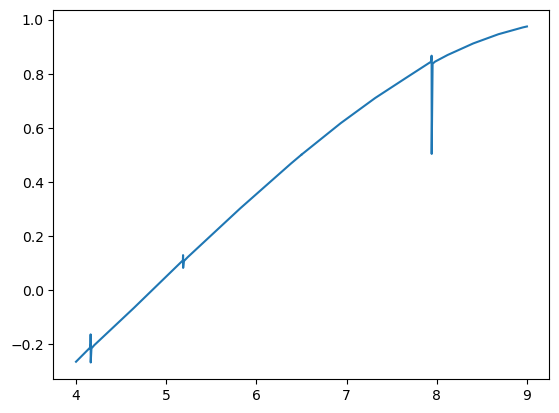

In [48]:
plt.plot(s21)
plt.show()

In [49]:
import sys

In [62]:
sys.path.append('C:\\lfl\\Documents\\lflpython\\')

In [64]:
import fitTools

In [65]:
fitTools.Resonator

AttributeError: module 'fitTools' has no attribute 'Resonator'

In [63]:
from fitTools.Resonator import *

ModuleNotFoundError: No module named 'fitTools.Resonator'

In [53]:
def get_real_and_imag(a_ii):
    return a_ii.values.real, a_ii.values.imag

s21real, s21imag = get_real_and_imag(df_s['S21'])
#y11real, y11imag = get_real_and_imag(df_y['Y11'])


dataframe_scattering[0]['Real(S21)'] = s21real
dataframe_scattering[0]['Imag(S21)'] = s21imag

  magnitude.show()



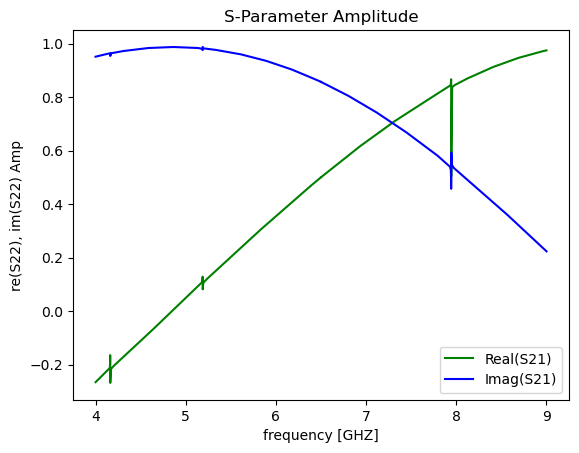

In [54]:
# Reference to current axis.
magnitude = plt.figure('Real S21, Imag S21')
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='Real(S21)', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='Imag(S21)', color = 'blue', ax = axis)
plt.title(f'S-Parameter Amplitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f're(S22), im(S22) Amp')
magnitude.show()

In [55]:
reals21 = dataframe_scattering[0]['Real(S21)']
imags21 = dataframe_scattering[0]['Imag(S21)']
freqs = np.array(list(reals21.keys())) * 1e9
I = np.array(list(reals21.values))
Q = np.array(list(imags21.values))

In [56]:
res = Resonator(f_data=freqs,z_data=I + 1j*Q)

NameError: name 'Resonator' is not defined